# Setting

In [1]:
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np

from models.shared_perceiver import CustomDataset, Perceiver, CombinedModel

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ["Opinion", "Art & Design", "Television"],
    ["Music", "Travel", "Real Estate"],
    ["Books", "Theater", "Health"],
    ["Sports", "Science", "Food"],
    ["Fashion & Style", "Movies", "Technology"],
    ["Dance", "Media", "Style"]
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

생성된 그룹별 CSV 파일 경로:
/home/youlee/n24news/n24news/regroup_1.csv
/home/youlee/n24news/n24news/regroup_2.csv
/home/youlee/n24news/n24news/regroup_3.csv
/home/youlee/n24news/n24news/regroup_4.csv
/home/youlee/n24news/n24news/regroup_5.csv
/home/youlee/n24news/n24news/regroup_6.csv


In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정

def seed_worker(worker_id): #데이터로더 난수고정
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(42)
g = torch.Generator()
g.manual_seed(42)
NUM_WORKERS = 4 # 서브프로세스관리자 수. 난수생성과 관련있습니다. 일단은 4로 고정합니다.


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

In [4]:
def tokenize_data(df, tokenizer=BertTokenizer.from_pretrained('bert-base-uncased'), MAX_LENGTH=128):
    input_ids, attention_masks = [], []
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)


# Functions

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  
        labels = batch['labels'].to(device)
        #print(f"🚀 input_ids.shape: {input_ids.shape}") 
        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        #print(f"🚀 outputs.shape: {outputs.shape}")
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [6]:
model_path = '/home/Minju/Perceiver/shared_layer_model'
loader_path = '/home/Minju/Perceiver/loader'

In [7]:
for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)
    sample = dataset [0]
    print(sample)
    print(len(dataset)) 

    dataloader = DataLoader(dataset, batch_size=2, shuffle=False, 
                            num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)
    first_batch = next(iter(dataloader))
    print(first_batch)
 


group 1 처리 중...
{'input_ids': tensor([ 101, 1996, 2317, 2160, 2003, 1037, 4556, 2806, 3538, 1997, 4294, 1010,
        4427, 2011, 3306, 1998, 3142, 3121, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0,

# Train 시작


group 1 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.0932, train acc: 0.3481
                               test loss: 0.8940, test acc: 0.5939
    epoch 5/40: train loss: 0.7838, train acc: 0.6302
                               test loss: 0.7593, test acc: 0.6435
    epoch 10/40: train loss: 0.6399, train acc: 0.7077
                               test loss: 0.7349, test acc: 0.6649
    epoch 15/40: train loss: 0.5709, train acc: 0.7491
                               test loss: 0.8003, test acc: 0.6737
    epoch 20/40: train loss: 0.5090, train acc: 0.7971
                               test loss: 0.8022, test acc: 0.6885
    epoch 25/40: train loss: 0.4688, train acc: 0.8213
                               test loss: 0.8042, test acc: 0.7023
    epoch 30/40: train loss: 0.4493, train acc: 0.8339
                               test loss: 0.8011, test acc: 0.7132
    epoch 35/40: train loss: 0.4397, train acc: 0.8402
                               test loss: 0.7954, test a

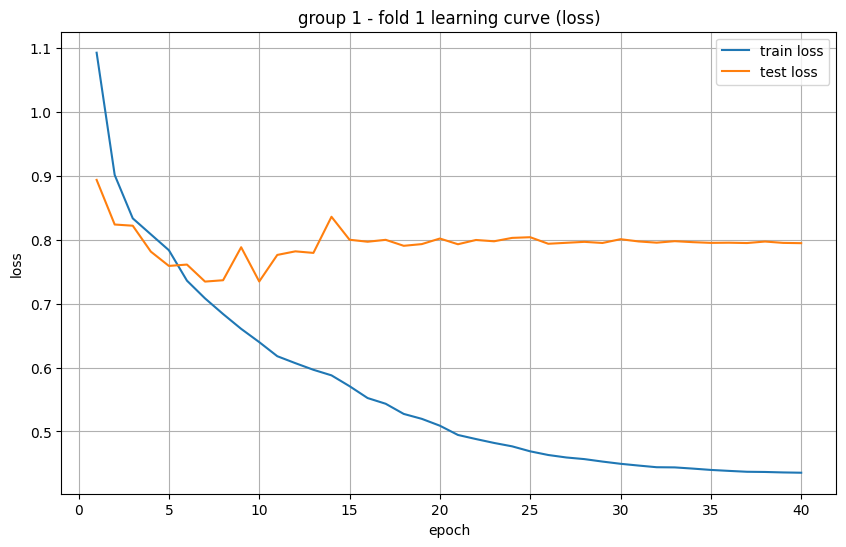

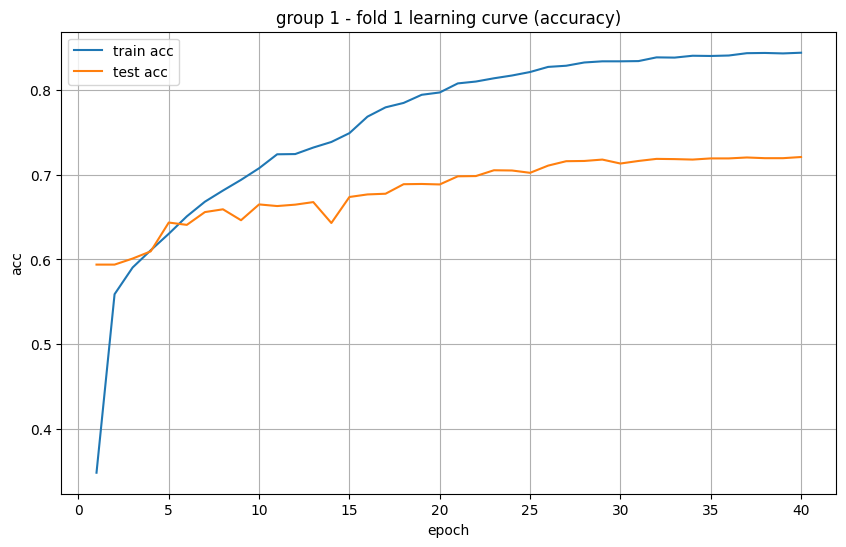

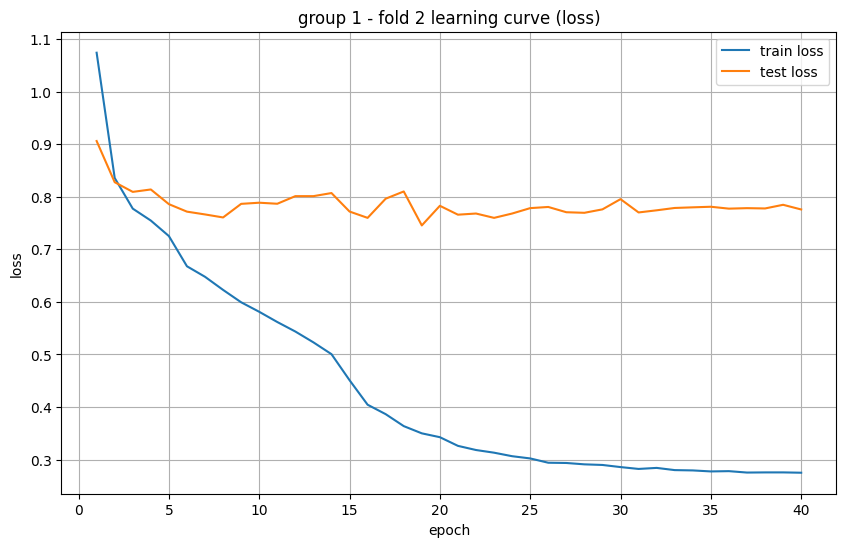

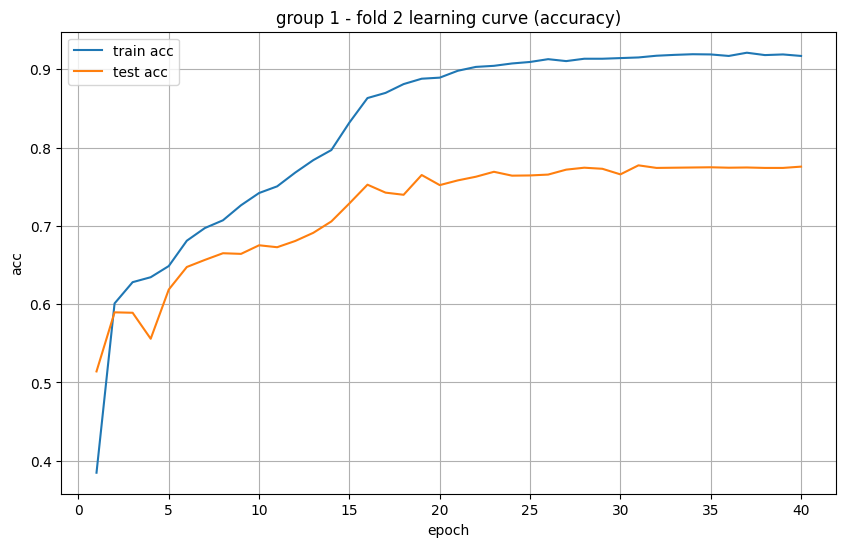

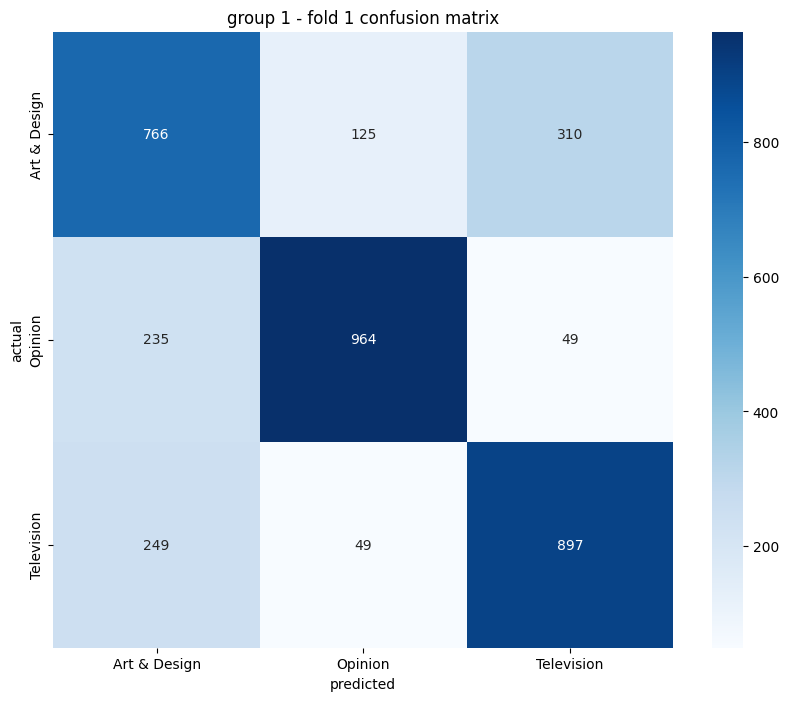

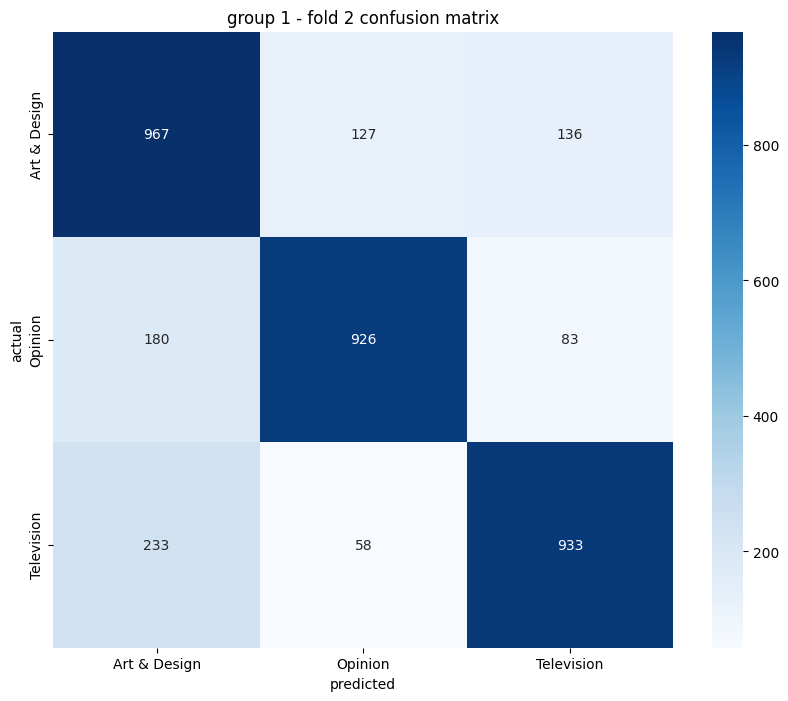


group 2 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1002, train acc: 0.3314
                               test loss: 1.0768, test acc: 0.4582
    epoch 5/40: train loss: 0.7164, train acc: 0.7189
                               test loss: 0.8243, test acc: 0.6614
    epoch 10/40: train loss: 0.5135, train acc: 0.8335
                               test loss: 0.8664, test acc: 0.6846
    epoch 15/40: train loss: 0.4161, train acc: 0.8824
                               test loss: 0.9284, test acc: 0.6915
    epoch 20/40: train loss: 0.3846, train acc: 0.8967
                               test loss: 0.9859, test acc: 0.6907
    epoch 25/40: train loss: 0.3454, train acc: 0.9047
                               test loss: 0.9745, test acc: 0.6935
    epoch 30/40: train loss: 0.3329, train acc: 0.9083
                               test loss: 0.9894, test acc: 0.6926
    epoch 35/40: train loss: 0.3256, train acc: 0.9105
                               test loss: 0.9952, test a

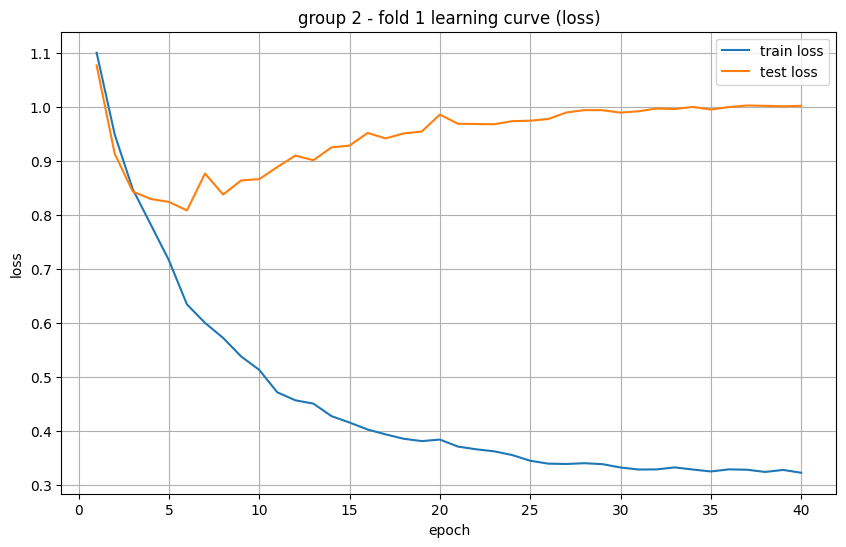

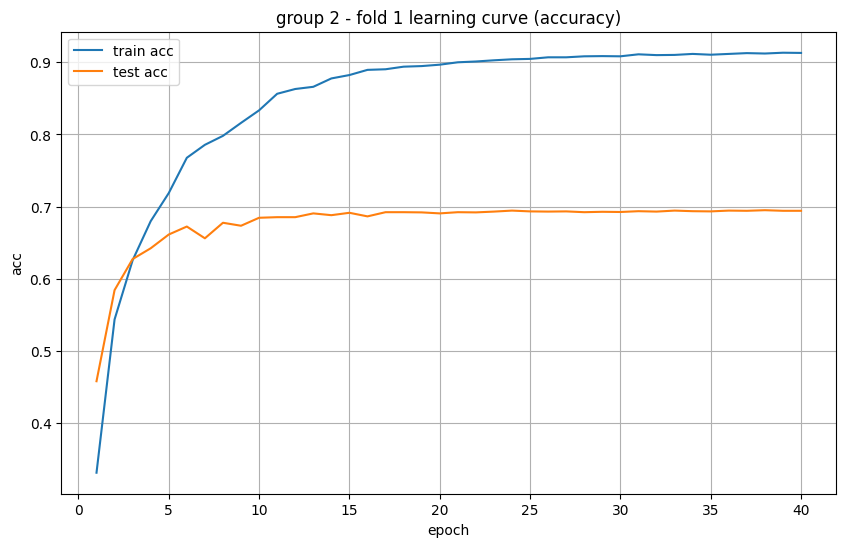

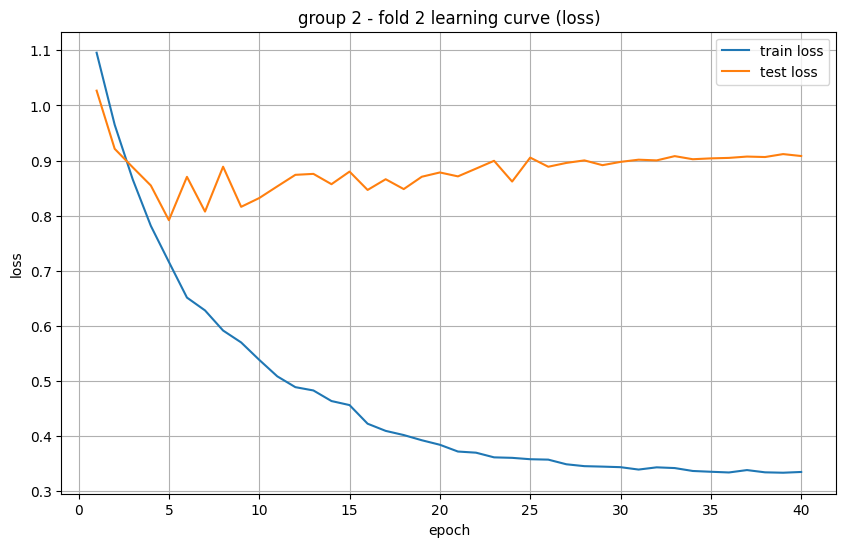

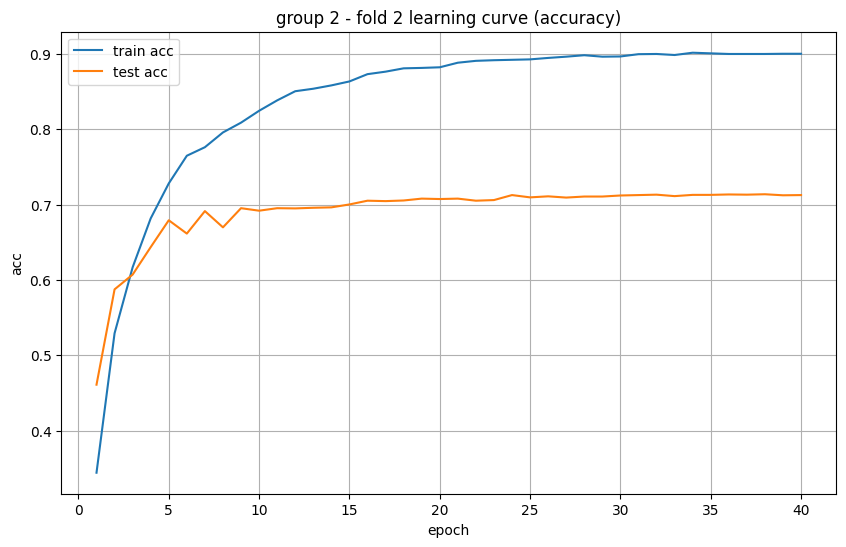

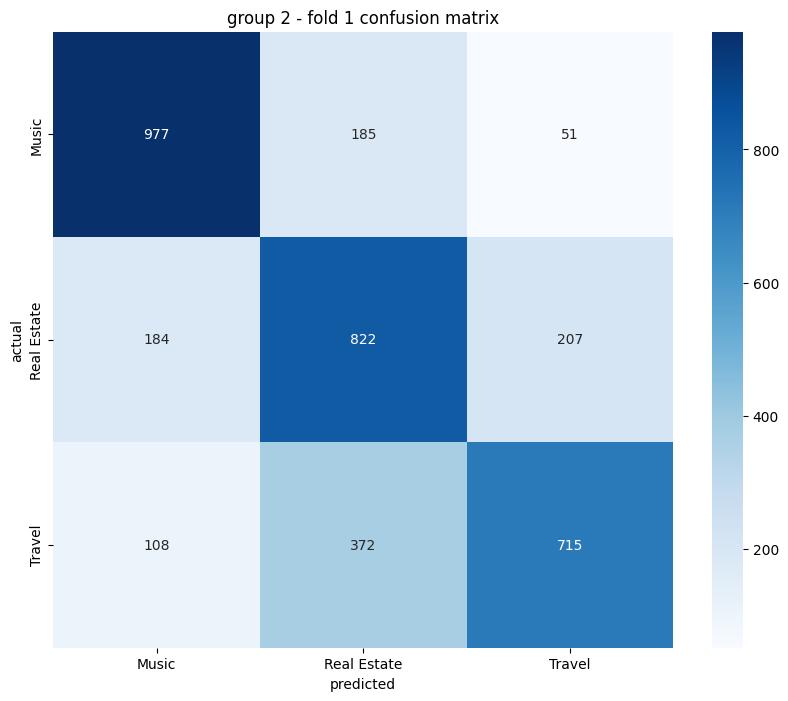

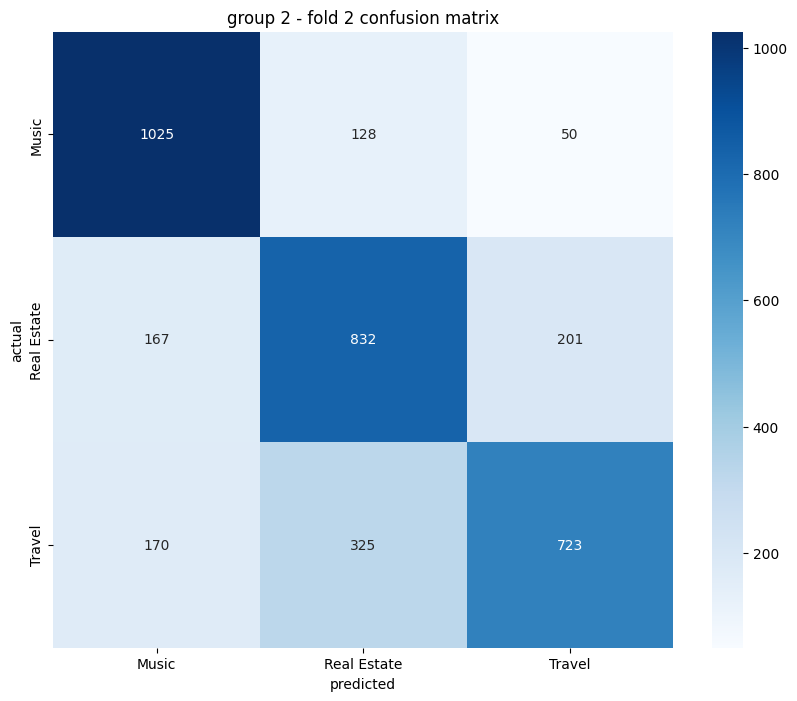


group 3 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1042, train acc: 0.3245
                               test loss: 1.0942, test acc: 0.3427
    epoch 5/40: train loss: 0.6641, train acc: 0.7375
                               test loss: 0.7529, test acc: 0.7120
    epoch 10/40: train loss: 0.5369, train acc: 0.7851
                               test loss: 0.7181, test acc: 0.7212
    epoch 15/40: train loss: 0.4244, train acc: 0.8075
                               test loss: 0.6907, test acc: 0.7286
    epoch 20/40: train loss: 0.3894, train acc: 0.8307
                               test loss: 0.7017, test acc: 0.7414
    epoch 25/40: train loss: 0.3599, train acc: 0.8617
                               test loss: 0.7086, test acc: 0.7577
    epoch 30/40: train loss: 0.3449, train acc: 0.8667
                               test loss: 0.7242, test acc: 0.7568
    epoch 35/40: train loss: 0.3402, train acc: 0.8669
                               test loss: 0.7265, test a

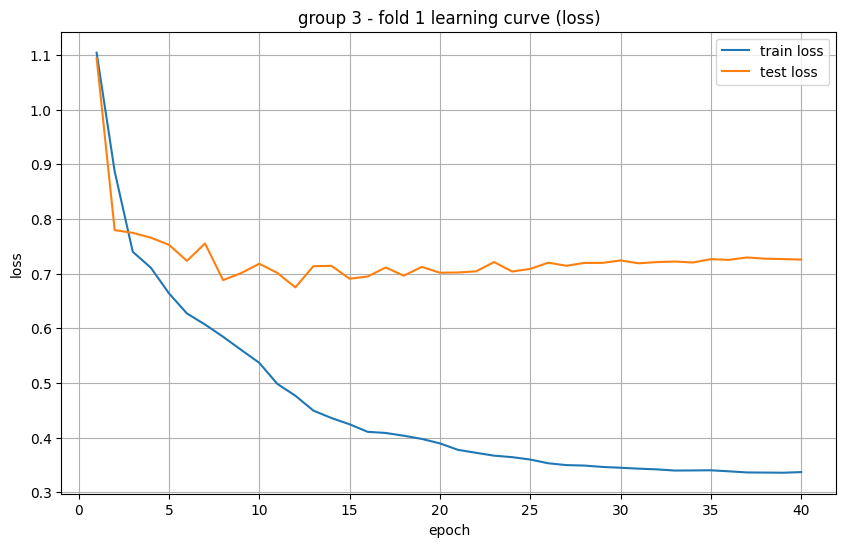

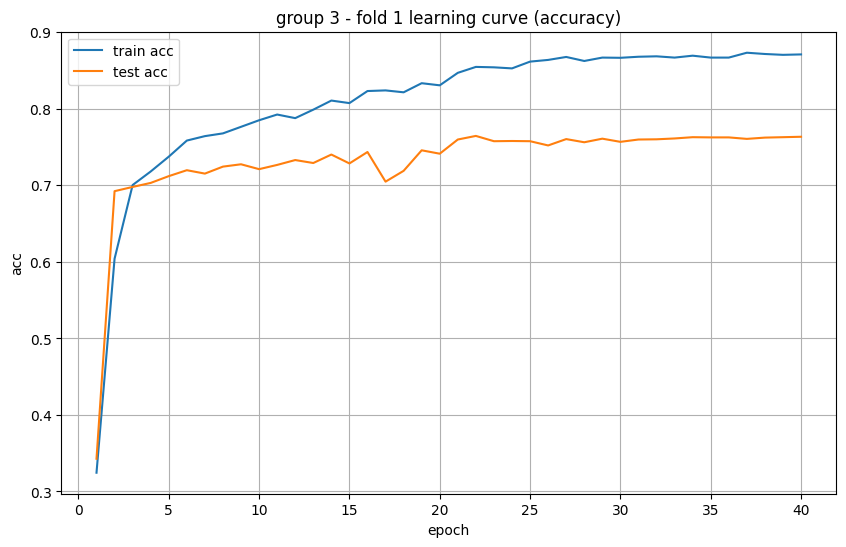

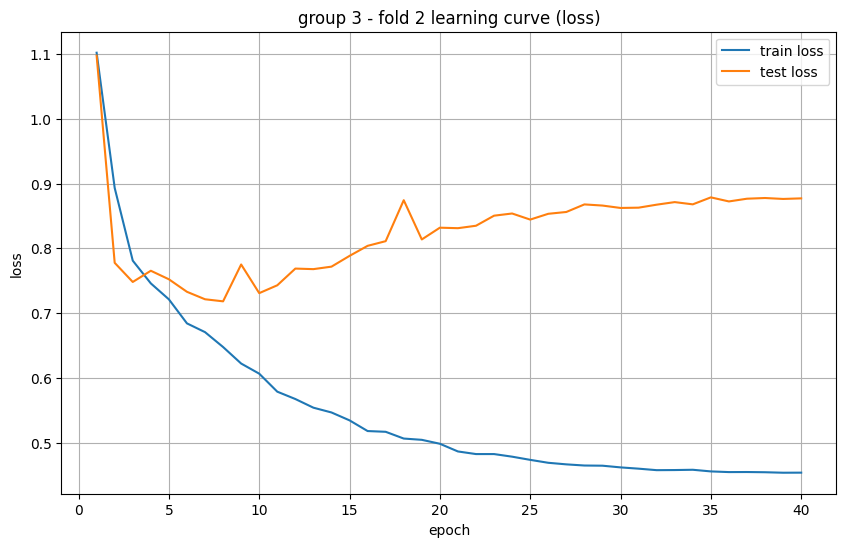

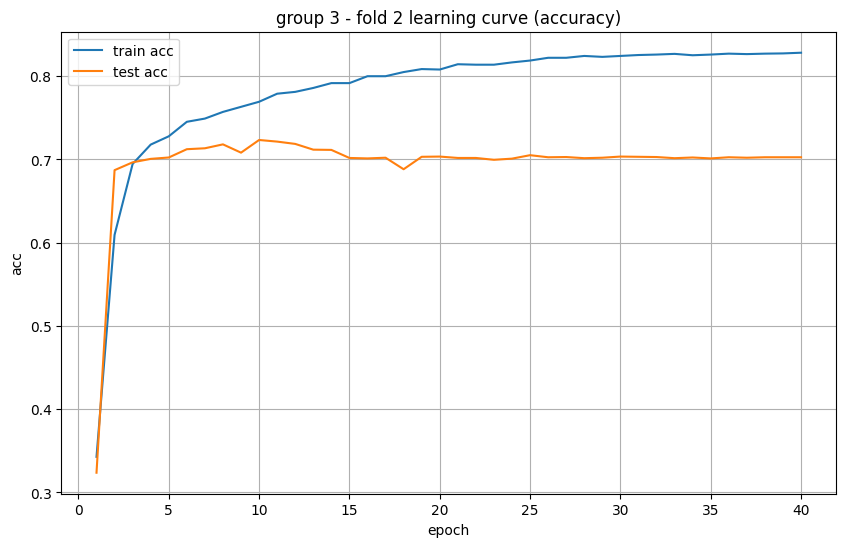

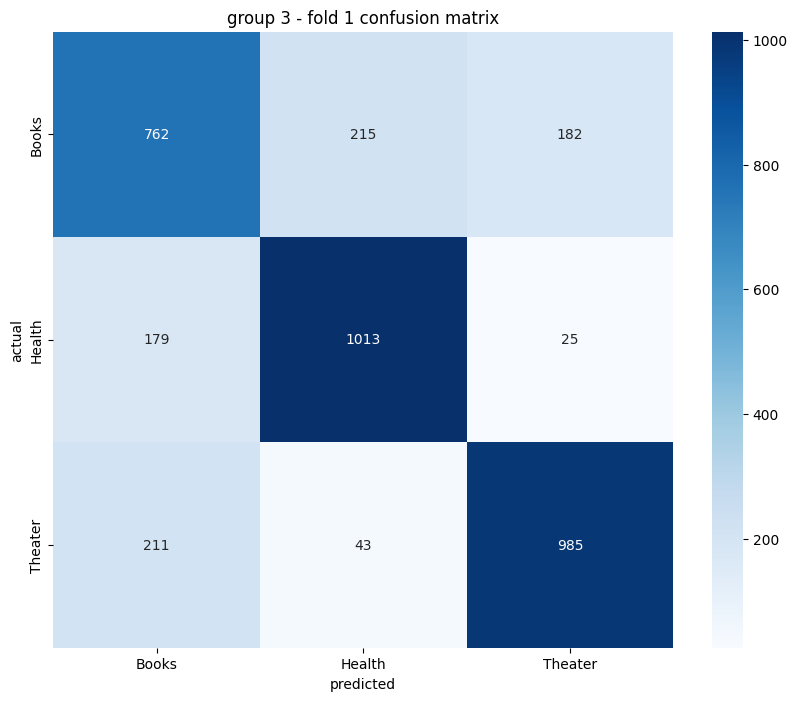

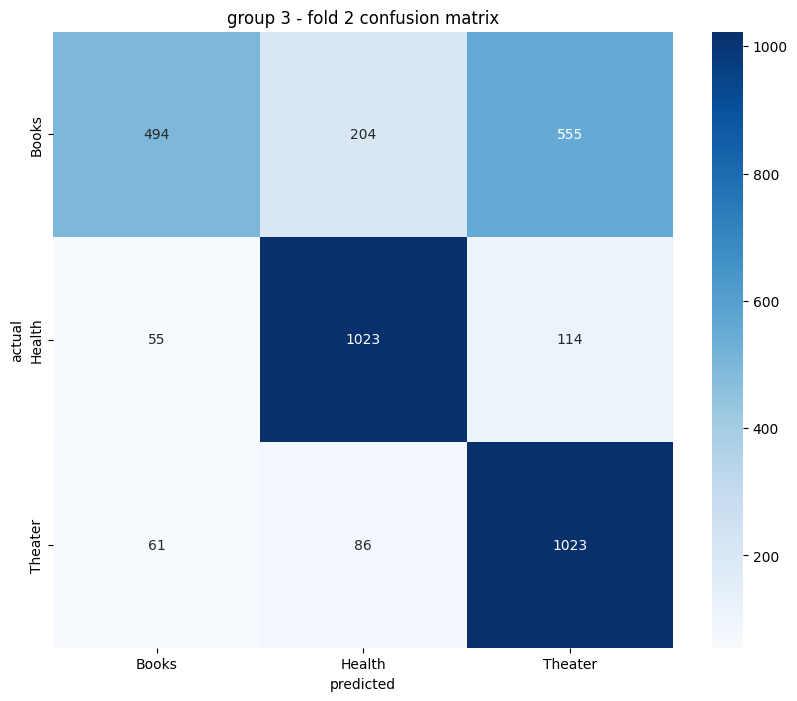


group 4 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1016, train acc: 0.3321
                               test loss: 1.1052, test acc: 0.3223
    epoch 5/40: train loss: 0.9726, train acc: 0.4806
                               test loss: 1.0229, test acc: 0.4312
    epoch 10/40: train loss: 0.9049, train acc: 0.5149
                               test loss: 0.9737, test acc: 0.4774
    epoch 15/40: train loss: 0.5214, train acc: 0.7994
                               test loss: 0.7607, test acc: 0.6981
    epoch 20/40: train loss: 0.4231, train acc: 0.8509
                               test loss: 0.7744, test acc: 0.7131
    epoch 25/40: train loss: 0.3780, train acc: 0.8749
                               test loss: 0.7855, test acc: 0.7209
    epoch 30/40: train loss: 0.3556, train acc: 0.8897
                               test loss: 0.7895, test acc: 0.7228
    epoch 35/40: train loss: 0.3491, train acc: 0.8924
                               test loss: 0.7975, test a

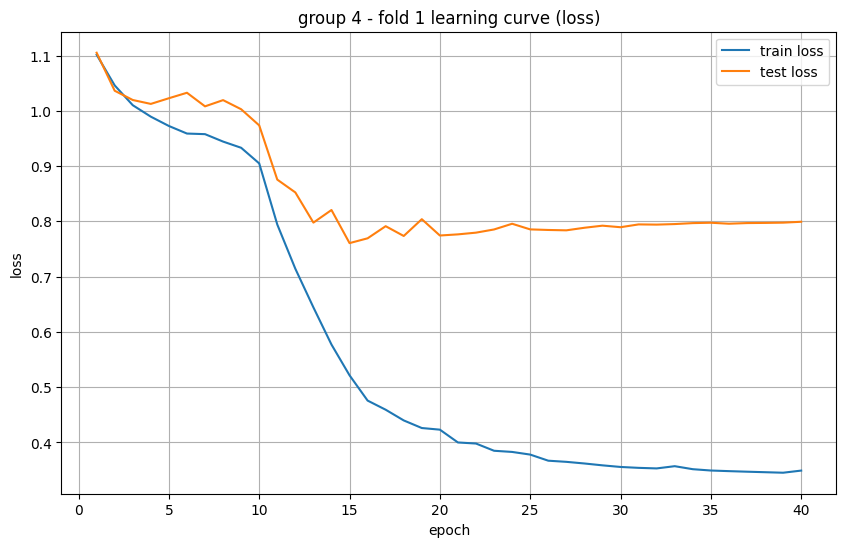

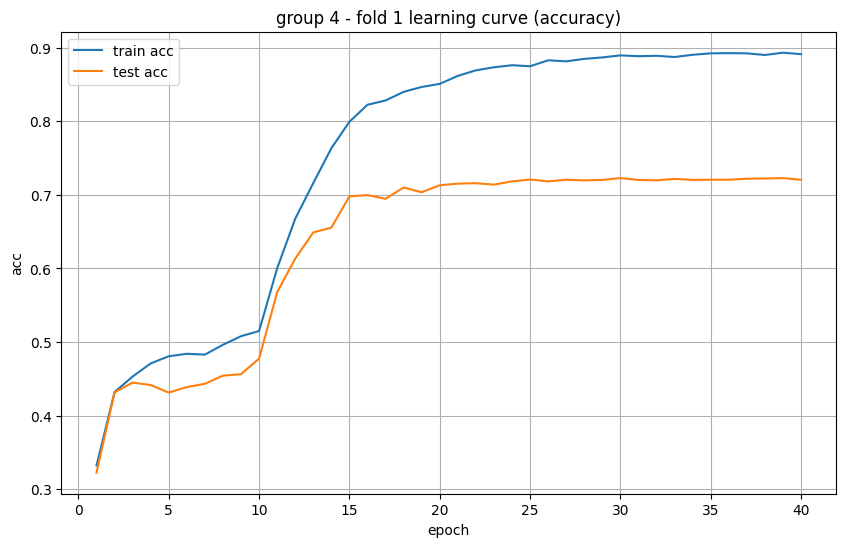

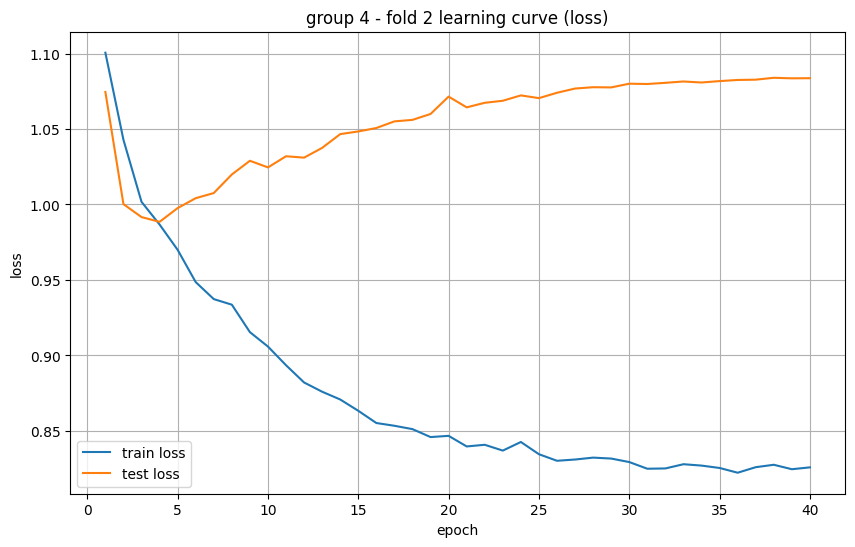

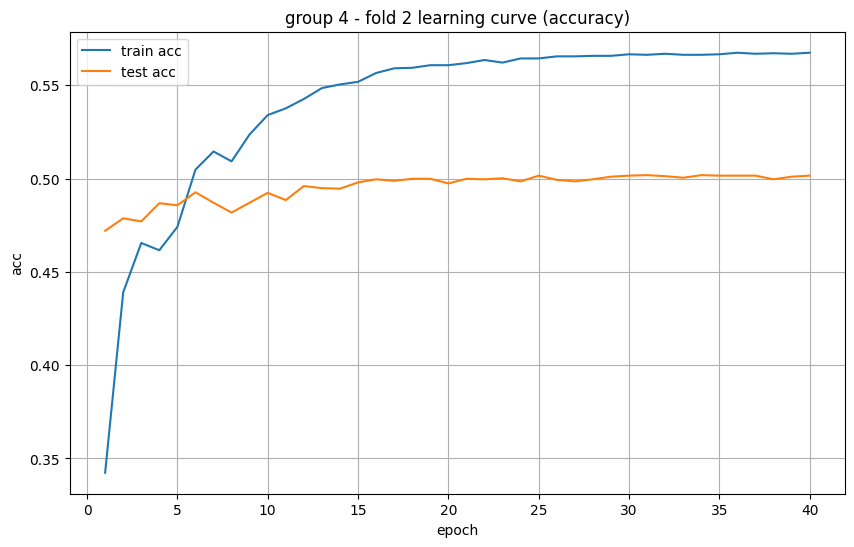

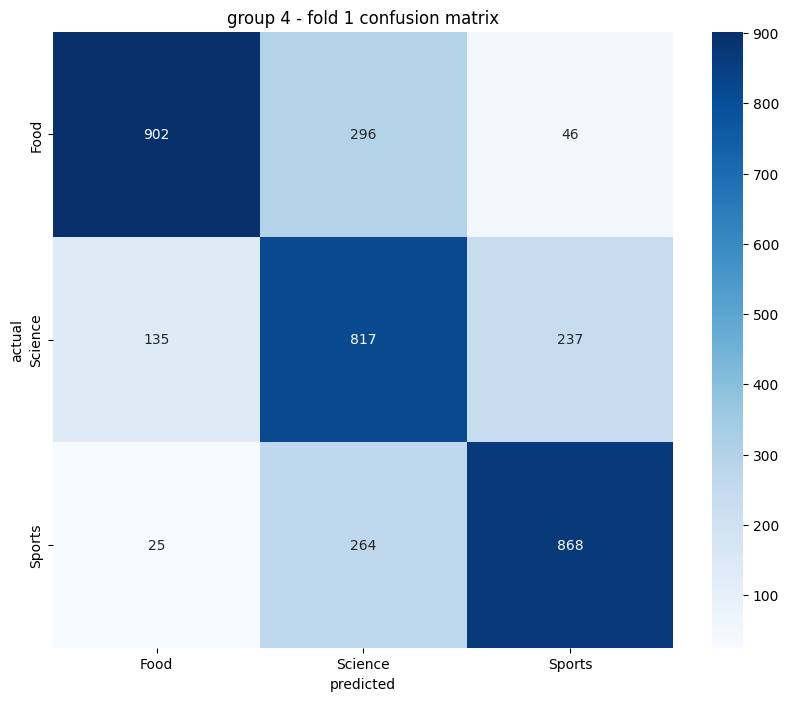

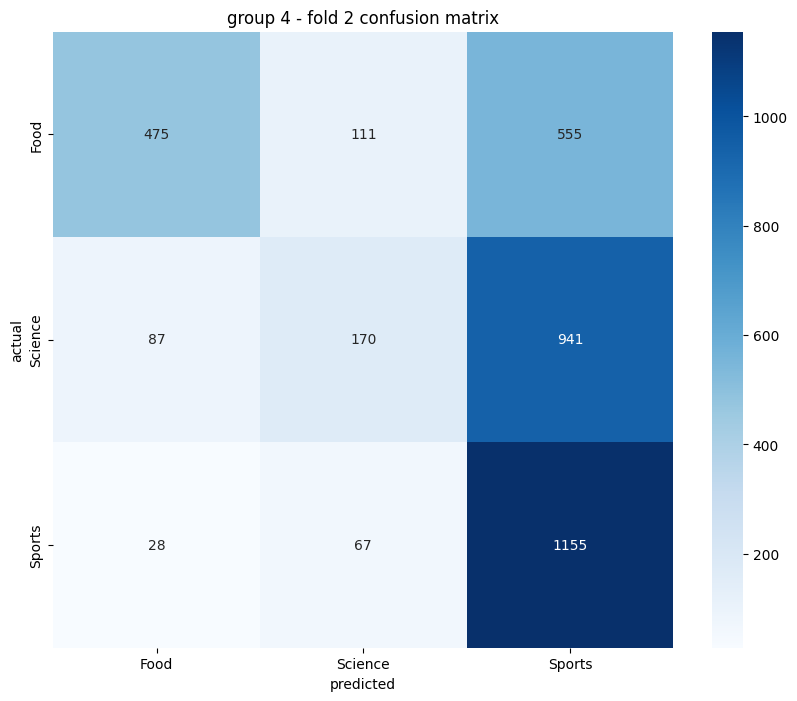


group 5 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1012, train acc: 0.3298
                               test loss: 1.1012, test acc: 0.3308
    epoch 5/40: train loss: 0.7628, train acc: 0.6817
                               test loss: 0.7027, test acc: 0.7338
    epoch 10/40: train loss: 0.5051, train acc: 0.8138
                               test loss: 0.6913, test acc: 0.7448
    epoch 15/40: train loss: 0.4252, train acc: 0.8539
                               test loss: 0.7602, test acc: 0.7403
    epoch 20/40: train loss: 0.3919, train acc: 0.8634
                               test loss: 0.8117, test acc: 0.7358
    epoch 25/40: train loss: 0.3729, train acc: 0.8732
                               test loss: 0.8396, test acc: 0.7324
    epoch 30/40: train loss: 0.3646, train acc: 0.8765
                               test loss: 0.8442, test acc: 0.7347
    epoch 35/40: train loss: 0.3583, train acc: 0.8774
                               test loss: 0.8468, test a

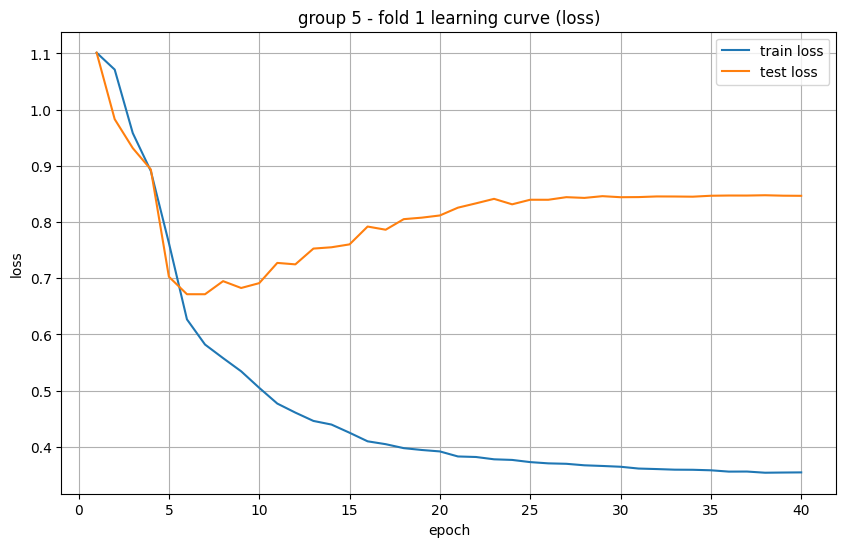

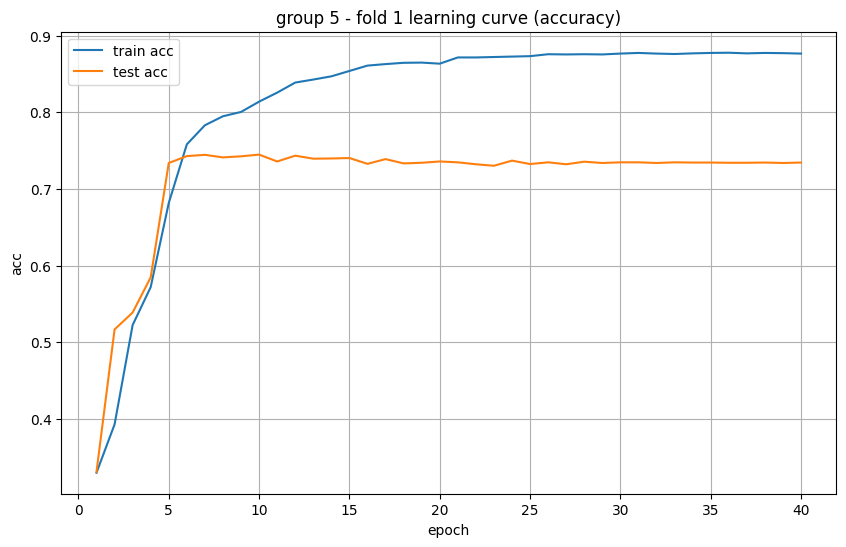

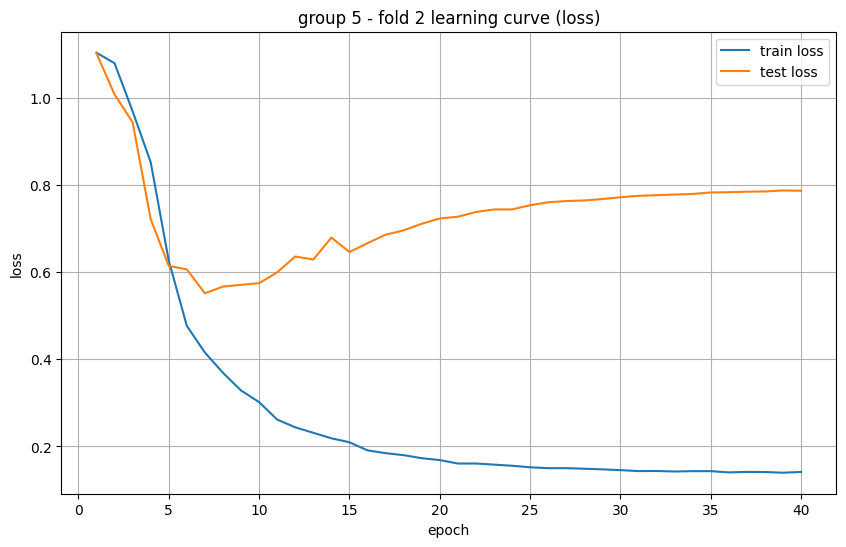

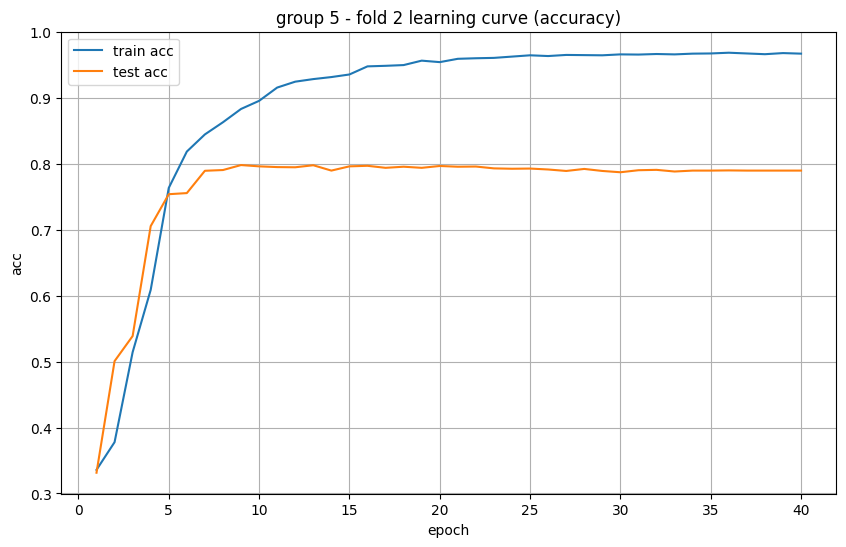

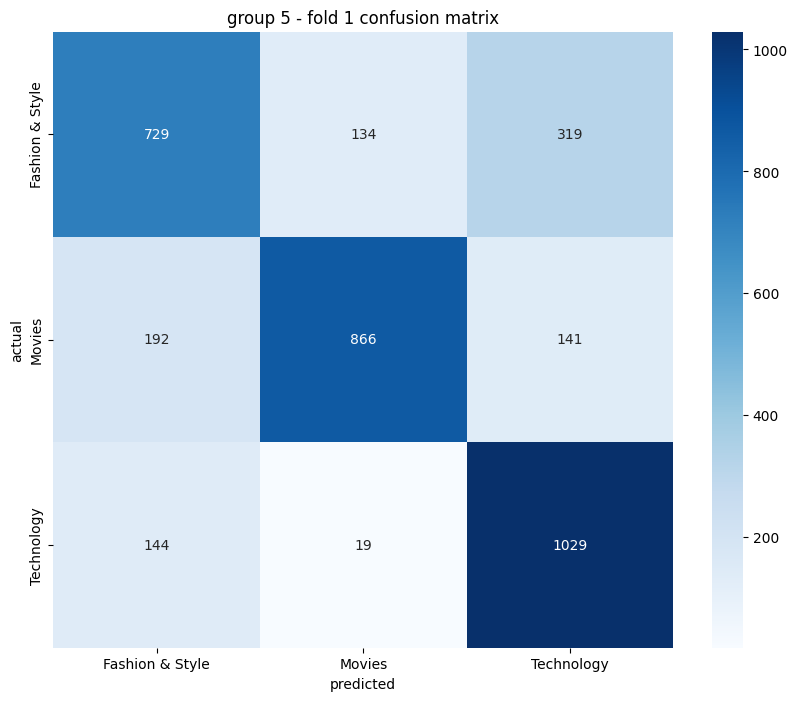

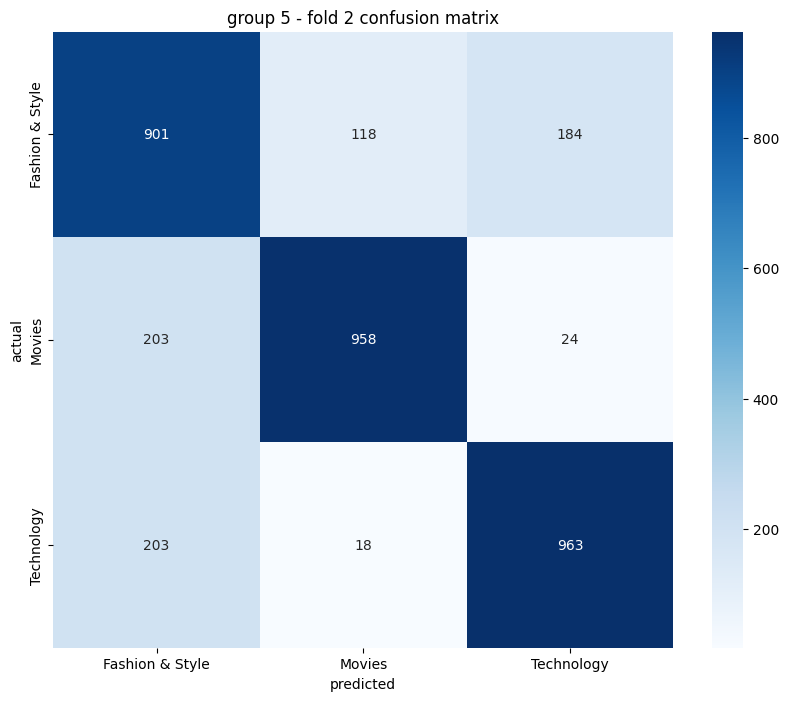


group 6 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1009, train acc: 0.3378
                               test loss: 1.0987, test acc: 0.3441
    epoch 5/40: train loss: 0.8973, train acc: 0.6095
                               test loss: 0.9374, test acc: 0.5844
    epoch 10/40: train loss: 0.7461, train acc: 0.7122
                               test loss: 0.9318, test acc: 0.6169
    epoch 15/40: train loss: 0.6561, train acc: 0.7637
                               test loss: 0.9680, test acc: 0.6309
    epoch 20/40: train loss: 0.6158, train acc: 0.7777
                               test loss: 0.9978, test acc: 0.6326
    epoch 25/40: train loss: 0.5959, train acc: 0.7885
                               test loss: 1.0151, test acc: 0.6385
    epoch 30/40: train loss: 0.5870, train acc: 0.7923
                               test loss: 1.0243, test acc: 0.6367
    epoch 35/40: train loss: 0.5833, train acc: 0.7931
                               test loss: 1.0280, test a

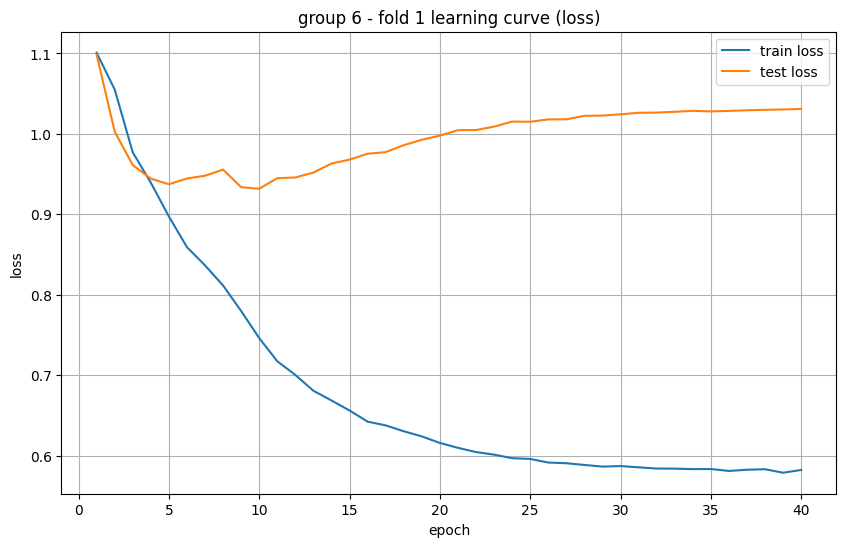

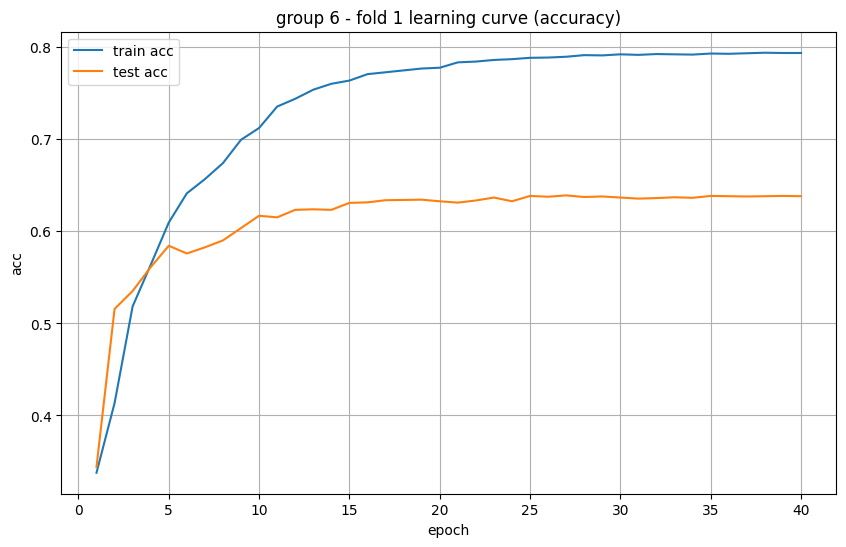

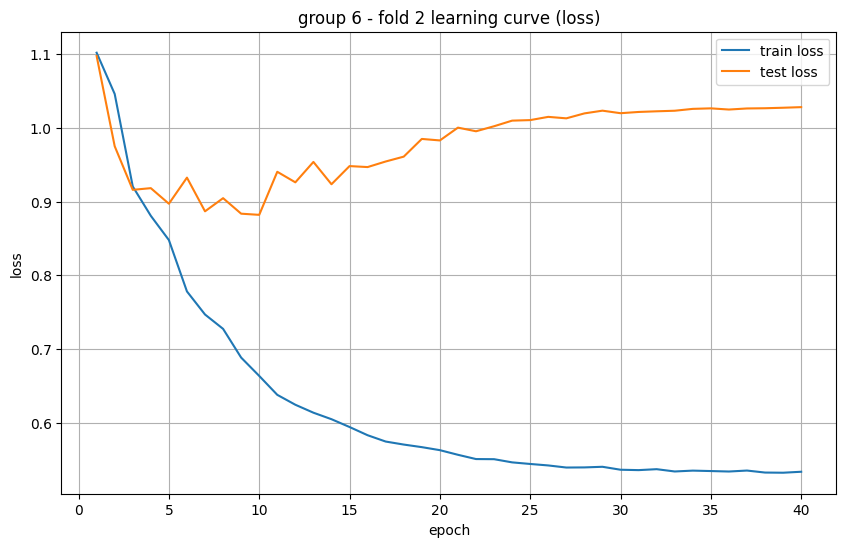

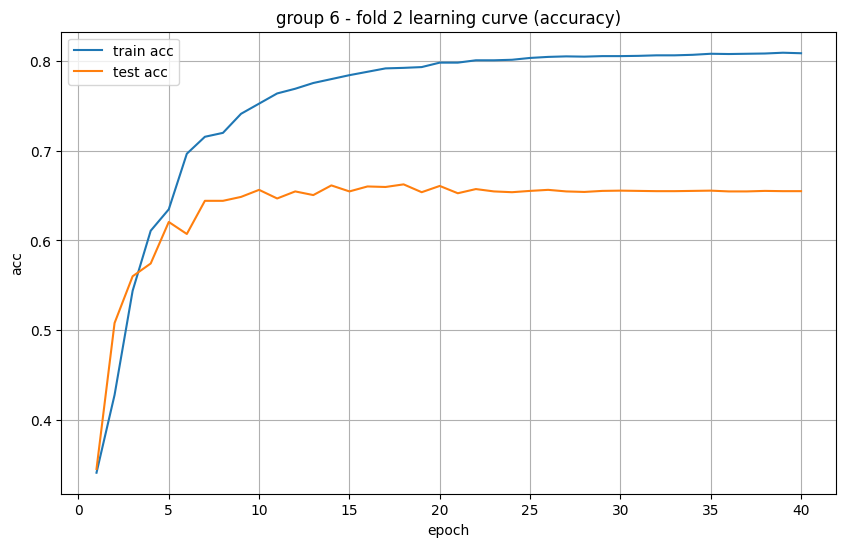

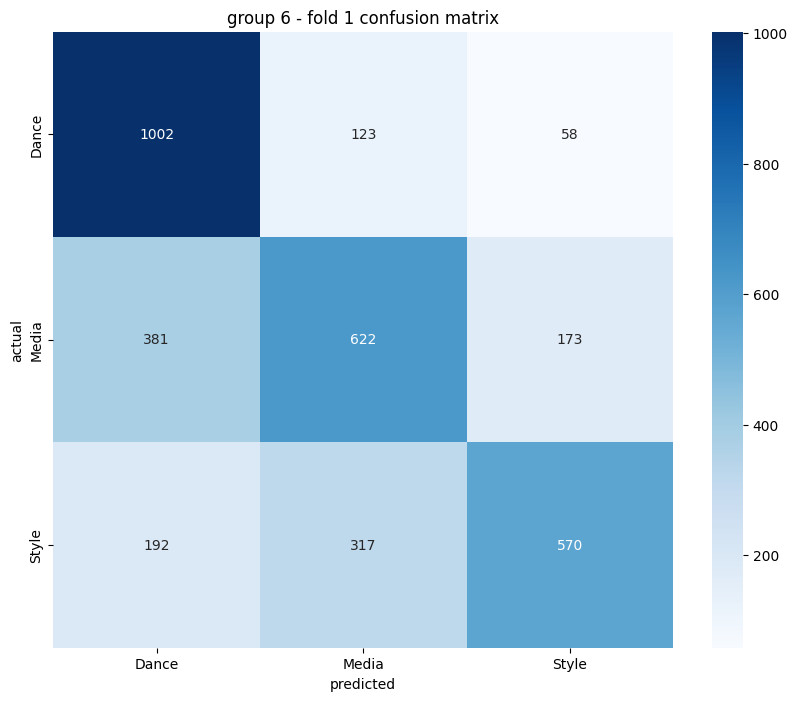

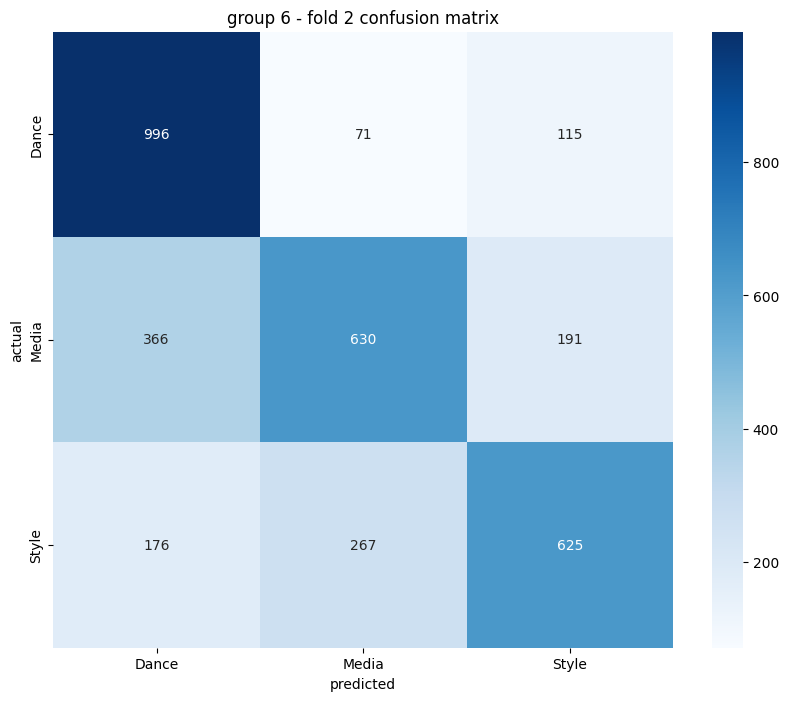


=== 모든 그룹의 요약 결과 ===

그룹 1 - 평균 테스트 정확도: 0.7483
  폴드 1: 테스트 정확도 = 0.7209
  폴드 2: 테스트 정확도 = 0.7757

그룹 2 - 평균 테스트 정확도: 0.7034
  폴드 1: 테스트 정확도 = 0.6943
  폴드 2: 테스트 정확도 = 0.7125

그룹 3 - 평균 테스트 정확도: 0.7331
  폴드 1: 테스트 정확도 = 0.7635
  폴드 2: 테스트 정확도 = 0.7026

그룹 4 - 평균 테스트 정확도: 0.6111
  폴드 1: 테스트 정확도 = 0.7206
  폴드 2: 테스트 정확도 = 0.5015

그룹 5 - 평균 테스트 정확도: 0.7622
  폴드 1: 테스트 정확도 = 0.7344
  폴드 2: 테스트 정확도 = 0.7900

그룹 6 - 평균 테스트 정확도: 0.6465
  폴드 1: 테스트 정확도 = 0.6382
  폴드 2: 테스트 정확도 = 0.6549


In [8]:
EPOCHS = 40
BATCH_SIZE = 32
K_FOLDS = 2
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수
LR = 5e-4

all_learning_curves = []
best_models = {} 

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []
    best_fold_acc = 0.0
    best_model = None
    best_valid_loader = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False,
                                 num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)

        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LR)  
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            current_lr = LR
            current_lr = scheduler.get_last_lr()[0]
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    epoch {epoch+1}/{EPOCHS}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
                print(f'                               test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
        if test_acc > best_fold_acc:
            best_fold_acc = test_acc
            best_model = model
            best_valid_loader = test_loader

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })
    

    # 모델 및 데이터로더 저장장
    model_save_path = f"{model_path}/text_model_{idx}.pkl"
    torch.save(best_model, model_save_path)
    print(f"Group {idx} 최고 모델 저장 완료: {model_save_path}")

    # val_loader_save_path = f"{loader_path}/text_val_loader_{idx}.pkl"
    # with open(val_loader_save_path, 'wb') as f:
    #     pickle.dump(best_valid_loader, f) 
    # print(f"Group {idx} 최고 valid loader 저장 완료: {val_loader_save_path}")
    
    
    # 결과 Analysis
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

  
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="train loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="test loss")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

   
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="train acc")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="test acc")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()

print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")

In [9]:
import pickle

file_path = "/home/youlee/perceiver/perceiver/loader/text_val_loader_1.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

type_of_data = type(data)
if hasattr(data, 'shape'):
    data_shape = data.shape
else:
    try:
        data_shape = (len(data), len(data[0]))
    except Exception as e:
        data_shape = f"Cannot determine shape: {e}"

type_of_data, data_shape


(torch.utils.data.dataloader.DataLoader,
 "Cannot determine shape: 'DataLoader' object is not subscriptable")

In [10]:
for batch in data:
  
    if isinstance(batch, dict):
        print({key: value.shape for key, value in batch.items()})

    elif isinstance(batch, tuple):
        print(f"Inputs shape: {batch[0].shape}, Labels shape: {batch[1].shape}")
    else:
        print(f"Unknown batch format: {type(batch)}")
    break  

{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
